# Train Kalman filter using Fastai using float64

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
import pandas as pd
import torch
import numpy as np

NameError: name 'ListNormal' is not defined

In [ ]:
@cache_disk("full_hai")
def load_data():
    return read_fluxnet_csv(hai_path, None, num_dtype=np.float64)

hai = load_data()

In [ ]:
model = KalmanFilter(**KalmanFilterTester(dtype=torch.float64).params)

In [ ]:
dls = make_dataloader(hai, 200, 10, bs=10) 

In [ ]:
len(hai) / 200 / 10 * .8

91.1808

In [ ]:
len(dls.train)

91

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss, cbs=[ShowGraphCallback, Float64Callback])

In [ ]:
len(dls.train)

91

### Only Gap Loss

In [ ]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,time


NotImplementedError: Module [KalmanFilter] is missing the required "forward" function

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.fit(10, 1e-2)

In [ ]:
# learn.recorder.plot_loss()

In [ ]:
# torch.save(learn.model, "trained_model_20_dec_f64.pickle")

In [ ]:
trained_state = learn.model.state_dict()

#### Results

In [ ]:
from meteo_imp.data_preparation import MeteoDataTest
from meteo_imp.kalman.imputation import KalmanImputation

In [ ]:
def gap2res(var_sel, gap_len, gap_start, block_start=1000, block_end=1200):
    data = MeteoDataTest(hai.iloc[block_start:block_end, :]).add_gap(gap_len, var_sel, gap_start)
    imp = KalmanImputation(data.data)
    imp.model.filter = learn.model # ensure float64 support
    imp.model.filter.load_state_dict(trained_state)
    return imp.to_result(data.data_compl_tidy, var_names= data.data.columns, units=units, pred_all=True)

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
check_posdef(learn.model.obs_cov.to(torch.float32))

In [ ]:
gap2res(var_sel, gap_start=30, gap_len=15, block_start=500, block_end=700).display_results()

## Loss All 

compute the loss for all predictions not only the gap

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(only_gap=False), cbs=[ShowGraphCallback, Float64Callback])

In [ ]:
learn.fit(10, 2e-3)

In [ ]:
learn.recorder.plot_loss()

Horrible idea ... probably by smoothing is too easy to predict the points that the parameters of the model have basically no influence.

Need to try with filtering 

## Loss Filter only 

compute the loss for all predictions not only the gap

In [ ]:
model = KalmanFilter(**KalmanFilterTester(dtype=torch.float64).params)

In [ ]:
model.use_smooth = False

In [ ]:
model.check_args = None

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(only_gap=False), cbs=[ShowGraphCallback, Float64Callback])

epoch,train_loss,valid_loss,time
0,7412.622489,6652.202241,03:45
1,5049.731810,2825.582725,03:44
2,1962.345019,903.253100,03:47
3,318.255686,-117.658645,03:44
4,-323.398913,-448.278246,03:47
5,-654.908696,-679.999570,03:43
6,-803.473786,-873.061342,03:46
7,-1016.195842,-1018.383004,03:45
8,-1142.367950,-1148.339634,03:46
9,-1260.992943,-1299.262096,03:41


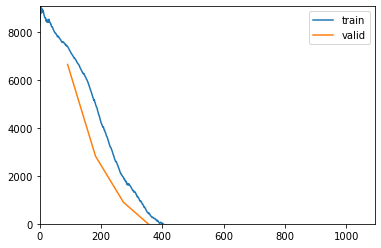

In [ ]:
learn.fit(12, 2e-3)

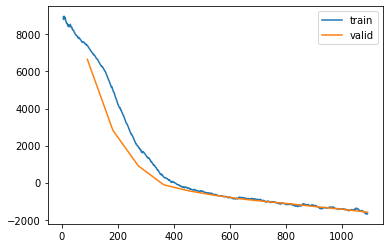

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.fit(10, 1e-3)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.fit(10, 5e-4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
trained_state = learn.model.state_dict()

## Results

In [ ]:
from meteo_imp.data_preparation import MeteoDataTest
from meteo_imp.kalman.imputation import KalmanImputation

In [ ]:
def gap2res(var_sel, gap_len, gap_start, block_start=1000, block_end=1200):
    data = MeteoDataTest(hai.iloc[block_start:block_end, :]).add_gap(gap_len, var_sel, gap_start)
    imp = KalmanImputation(data.data)
    imp.model.filter = learn.model # ensure float64 support
    imp.model.filter.load_state_dict(trained_state)
    return imp.to_result(data.data_compl_tidy, var_names= data.data.columns, units=units, pred_all=True)

In [ ]:
var_sel = data.data.columns

In [ ]:
%time gap2res(var_sel, 10, 10)

In [ ]:
gaps = [2, 5, 7, 10, 20, 30, 50, 100]
gap_starts = [0, 30, 60, 90]

In [ ]:
from ipywidgets import interact_manual, IntSlider

In [ ]:
#| include: false
@interact_manual(TA=True,
                 SW_IN=True,
                 VPD=True,
                 gap_len=IntSlider(10, 1,100),
                 gap_start=IntSlider(30, 1,100),
                 block_start = IntSlider(1000, 0, 20_000, 1000),
                 block_len = IntSlider(200, 10, 1000, 10)
        )
def show_diff_gaps_res(TA, SW_IN, VPD, gap_len, gap_start, block_start, block_len):
    var_sel = []
    if TA: var_sel.append('TA')
    if SW_IN: var_sel.append('SW_IN')
    if VPD: var_sel.append('VPD')
    var_sel = (*var_sel,)
    gap2res(var_sel, gap_len, gap_start, block_start, block_start + block_len).display_results()
    